In [1]:
import numpy as np
import tensorflow as tf
import re
import string
import matplotlib.pyplot as plt

class CustomTextVectorizationLayer(tf.keras.layers.experimental.preprocessing.TextVectorization):
    def __init__(self, raw_ds):
        docs_ds = raw_ds.map(lambda x, y: x)
        super(CustomTextVectorizationLayer, self).__init__(
            standardize=self.standardization, 
            max_tokens=self.analyse_dataset(docs_ds) + 4
        )
        self.adapt(docs_ds)
        self.vocab_size = self._max_tokens
        print('Effective vocabulary size:', len(self.get_vocabulary()))
    
    def standardization(self, input_data):
        output = tf.strings.lower(input_data, encoding='utf-8')
        output = tf.strings.regex_replace(output, '[%s]' % re.escape(string.punctuation), '')
        output = tf.strings.regex_replace(output, '[%s]' % (b'\xc2\xa0'.decode() + b'\xe2\xa0\x80'.decode()), ' ')
        return output
    
    def analyse_dataset(self, docs_ds):
        words_ds = docs_ds.map(lambda document: tf.strings.split(self.standardization(document))).unbatch()
        vocab_ds = words_ds.flat_map(tf.data.Dataset.from_tensor_slices).apply(tf.data.experimental.unique())
        vocab_size = vocab_ds.reduce(0, lambda count, x: count + 1).numpy()
        return vocab_size
    
class PositionalEncodingLayer(tf.keras.layers.Layer):
    def __init__(self, emb_dim, max_seq_len):
        super(PositionalEncodingLayer, self).__init__()
        # call inputs = [batch_size, seq_len, emb_dim]
        emb_channels = np.arange(emb_dim)[np.newaxis, :]
        seq_positions = np.arange(max_seq_len)[:, np.newaxis]
        angles = seq_positions * np.power(10000, 2 * (emb_channels // 2) / emb_dim)
        enc_positions = np.ndarray(angles.shape)
        enc_positions[:, 0::2] = np.sin(angles[:, 0::2])
        enc_positions[:, 1::2] = np.cos(angles[:, 1::2])
        enc_positions = enc_positions[np.newaxis, ...]
        self.enc_positions = tf.cast(enc_positions, dtype=tf.float32)
    
    def call(self, inputs):
        # inputs -> [batch_size, seq_len, emb_dim]
        # self.enc_positions -> [1, max_seq_len, emb_dim]
        # amplify input by sqrt(emb_dim)
        scale = tf.cast(tf.shape(inputs)[-1], tf.float32)
        inputs = inputs * scale 
        encoded = self.enc_positions[:, :tf.shape(inputs)[1], :]
        return inputs + encoded
    
class MultiheadSelfAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, emb_dim, num_heads):
        super(MultiheadSelfAttentionLayer, self).__init__()
        assert emb_dim % num_heads == 0
        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.proj_dim = emb_dim // num_heads
        # Q, K, V and Z(out) linear layers
        self.query_lin = tf.keras.layers.Dense(emb_dim)
        self.key_lin = tf.keras.layers.Dense(emb_dim)        
        self.value_lin = tf.keras.layers.Dense(emb_dim)
        self.out_lin = tf.keras.layers.Dense(emb_dim)
        
    def call(self, inputs):
        # inputs -> [batch_size, seq_len, emb_dim]
        # get Q, K, V from inputs
        query = self.query_lin(inputs)
        key = self.key_lin(inputs)
        value = self.value_lin(inputs)
        # split Q, K, V between heads
        # Q, K, V -> [batch_size, num_heads, seq_len, proj_dim]
        query = self.head_split(query)
        key = self.head_split(key)
        value = self.head_split(value)
        # compute attention
        attention = self.attention(query, key, value)
        # attention -> [batch_size, seq_len, emb_dim]
        attention = self.head_concat(attention)
        output = self.out_lin(attention)
        return output
        
    def head_split(self, x):
        # x -> [batch_size, seq_len, emb_dim]
        # y -> [batch_size, num_heads, seq_len, proj_dim]
        y = tf.reshape(x, (tf.shape(x)[0], -1, self.num_heads, self.proj_dim))
        y = tf.transpose(y, perm=[0, 2, 1, 3])
        return y
    
    def head_concat(self, x):
        # x -> [batch_size, num_heads, seq_len, proj_dim]
        # y -> [batch_size, seq_len, emb_dim]
        y = tf.transpose(x, perm=[0, 2, 1, 3])
        y = tf.reshape(y, (tf.shape(x)[0], -1, self.emb_dim))
        return y
    
    def attention(self, query, key, value):
        # score -> [batch_size, num_heads, seq_len, proj_dim, proj_dim]
        score = tf.matmul(query, key, transpose_b=True)
        scaled_score = score / tf.math.sqrt(tf.cast(self.proj_dim, dtype=tf.float32))
        # weights -> [proj_dim]
        weights = tf.nn.softmax(scaled_score, axis=-1)
        # output -> [batch_size, num_heads, seq_len, proj_dim]
        output = tf.matmul(weights, value)
        return output
    
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, ff_dim, emb_dim, num_heads):
        super(EncoderLayer, self).__init__()
        self.attention_layer = MultiheadSelfAttentionLayer(emb_dim, num_heads)
        self.feedforward_network = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation='relu'),
            tf.keras.layers.Dense(emb_dim)
        ])
        self.normalization_layer1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.normalization_layer2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    def call(self, inputs):
        # residual connection
        attention_outputs = self.attention_layer(inputs)
        attention_outputs = self.normalization_layer1(inputs + attention_outputs)
        feedforward_outputs = self.feedforward_network(attention_outputs)
        feedforward_outputs = self.normalization_layer2(attention_outputs + feedforward_outputs)
        return feedforward_outputs

In [2]:
train_raw_ds = tf.keras.preprocessing.text_dataset_from_directory(
    directory='./data',
    validation_split=0.2, 
    subset='training',
    batch_size=8,
    shuffle=True,
    seed=123
)
test_raw_ds = tf.keras.preprocessing.text_dataset_from_directory(
    directory='./data',
    validation_split=0.2, 
    subset='validation',
    batch_size=8,
    shuffle=True,
    seed=123
)

text_vectorization = CustomTextVectorizationLayer(train_raw_ds)

Found 1200 files belonging to 3 classes.
Using 960 files for training.
Found 1200 files belonging to 3 classes.
Using 240 files for validation.
Effective vocabulary size: 20734


In [5]:
# Global parameters
emb_dim = 128
max_seq_len = 10000
num_heads = 4
ff_dim = 128

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    text_vectorization,
    tf.keras.layers.Embedding(text_vectorization.vocab_size, emb_dim),
    PositionalEncodingLayer(emb_dim, max_seq_len),
    EncoderLayer(ff_dim, emb_dim, num_heads),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(emb_dim, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
custom_text_vectorization_la (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 128)         2654208   
_________________________________________________________________
positional_encoding_layer_1  (None, None, 128)         0         
_________________________________________________________________
encoder_layer_1 (EncoderLaye (None, None, 128)         99584     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_15 (Dense)             (None, 3)                

Epoch 1/6
120/120 [==============================] - 44s 369ms/step - loss: 0.4053 - acc: 0.8281 - val_loss: 0.1676 - val_acc: 0.9292
Epoch 2/6
120/120 [==============================] - 42s 349ms/step - loss: 0.1153 - acc: 0.9625 - val_loss: 0.0597 - val_acc: 0.9875
Epoch 3/6
120/120 [==============================] - 42s 347ms/step - loss: 0.0382 - acc: 0.9865 - val_loss: 0.0847 - val_acc: 0.9750
Epoch 4/6
120/120 [==============================] - 42s 352ms/step - loss: 0.0308 - acc: 0.9917 - val_loss: 0.0807 - val_acc: 0.9792
Epoch 5/6
120/120 [==============================] - 45s 376ms/step - loss: 0.0179 - acc: 0.9927 - val_loss: 0.0837 - val_acc: 0.9833
Epoch 6/6
120/120 [==============================] - 43s 358ms/step - loss: 0.0159 - acc: 0.9906 - val_loss: 0.0753 - val_acc: 0.9750


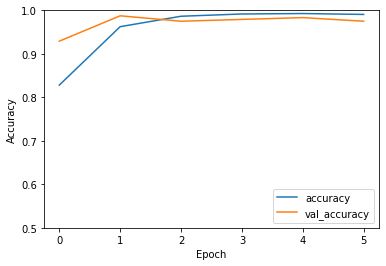

In [6]:
history = model.fit(
    train_raw_ds,
    validation_data=test_raw_ds, 
    epochs=4)

plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
custom_text_vectorization_la (None, None)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 64)          1327104   
_________________________________________________________________
positional_encoding_layer_2  (None, None, 64)          0         
_________________________________________________________________
encoder_layer_2 (EncoderLaye (None, None, 64)          25216     
_________________________________________________________________
global_average_pooling1d_2 ( (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_23 (Dense)             (None, 3)                

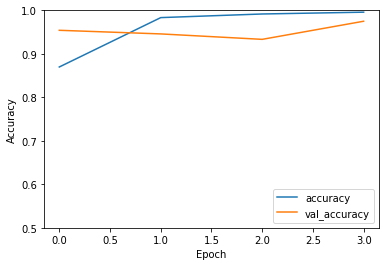

In [7]:
# Global parameters
emb_dim = 64
max_seq_len = 10000
num_heads = 4
ff_dim = 64

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    text_vectorization,
    tf.keras.layers.Embedding(text_vectorization.vocab_size, emb_dim),
    PositionalEncodingLayer(emb_dim, max_seq_len),
    EncoderLayer(ff_dim, emb_dim, num_heads),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(emb_dim, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

history = model.fit(
    train_raw_ds,
    validation_data=test_raw_ds, 
    epochs=4)

plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
custom_text_vectorization_la (None, None)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 64)          1327104   
_________________________________________________________________
positional_encoding_layer_3  (None, None, 64)          0         
_________________________________________________________________
encoder_layer_3 (EncoderLaye (None, None, 64)          25216     
_________________________________________________________________
encoder_layer_4 (EncoderLaye (None, None, 64)          25216     
_________________________________________________________________
global_average_pooling1d_3 ( (None, 64)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 64)               

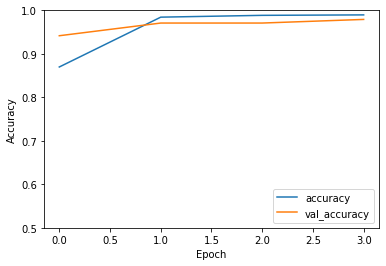

In [8]:
# Global parameters
emb_dim = 64
max_seq_len = 10000
num_heads = 4
ff_dim = 64

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    text_vectorization,
    tf.keras.layers.Embedding(text_vectorization.vocab_size, emb_dim),
    PositionalEncodingLayer(emb_dim, max_seq_len),
    EncoderLayer(ff_dim, emb_dim, num_heads),
    EncoderLayer(ff_dim, emb_dim, num_heads),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(emb_dim, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

history = model.fit(
    train_raw_ds,
    validation_data=test_raw_ds, 
    epochs=4)

plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
custom_text_vectorization_la (None, None)              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, None, 128)         2654208   
_________________________________________________________________
positional_encoding_layer_4  (None, None, 128)         0         
_________________________________________________________________
encoder_layer_5 (EncoderLaye (None, None, 128)         99584     
_________________________________________________________________
encoder_layer_6 (EncoderLaye (None, None, 128)         99584     
_________________________________________________________________
global_average_pooling1d_4 ( (None, 128)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 128)             

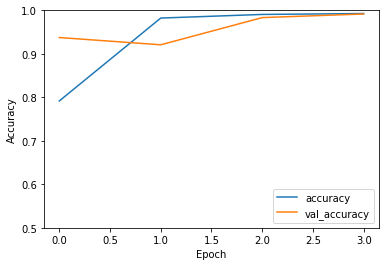

In [9]:
# Global parameters
emb_dim = 128
max_seq_len = 10000
num_heads = 4
ff_dim = 128

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    text_vectorization,
    tf.keras.layers.Embedding(text_vectorization.vocab_size, emb_dim),
    PositionalEncodingLayer(emb_dim, max_seq_len),
    EncoderLayer(ff_dim, emb_dim, num_heads),
    EncoderLayer(ff_dim, emb_dim, num_heads),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(emb_dim, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

history = model.fit(
    train_raw_ds,
    validation_data=test_raw_ds, 
    epochs=4)

plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

In [11]:
model.fit(
    train_raw_ds,
    validation_data=test_raw_ds, 
    epochs=1)

120/120 [==============================] - 84s 702ms/step - loss: 0.0134 - acc: 0.9937 - val_loss: 0.0557 - val_acc: 0.9875
